In [1]:
!pip install -q kaggle vaderSentiment xgboost category_encoders openpyxl

import os, json, ast, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RND = 42
sns.set_theme(style="whitegrid")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.1 MB/s eta 0:00:00


In [2]:
# Load Datasets
# -----------------------------
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
TMDB_SLUG = "tmdb/tmdb-movie-metadata"
IMDB_50K_SLUG = "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"

def try_download():
    try:
        if not Path("/root/.kaggle/kaggle.json").exists() and Path("kaggle.json").exists():
            os.makedirs("/root/.kaggle", exist_ok=True)
            os.system("cp kaggle.json /root/.kaggle/kaggle.json")
            os.chmod("/root/.kaggle/kaggle.json", 0o600)
        print("Downloading Kaggle datasets...")
        !kaggle datasets download -d {TMDB_SLUG} -p {DATA_DIR} --unzip
        !kaggle datasets download -d {IMDB_50K_SLUG} -p {DATA_DIR} --unzip
        print("✅ Download complete")
    except Exception as e:
        print("⚠️ Kaggle download skipped:", e)
        print("➡️ Please upload TMDB & IMDB CSVs manually to /content/data/")

try_download()

# Load TMDB
tmdb_file = next((f for f in DATA_DIR.glob("*tmdb*movies.csv")), None)
if tmdb_file is None:
    raise FileNotFoundError("Upload tmdb_5000_movies.csv to /content/data/")
tmdb = pd.read_csv(tmdb_file)

# Load IMDB reviews
imdb_file = next((f for f in DATA_DIR.glob("*IMDB*Dataset.csv")), None)
if imdb_file is None:
    raise FileNotFoundError("Upload IMDB Dataset.csv to /content/data/")
reviews = pd.read_csv(imdb_file)

print("\nTMDB shape:", tmdb.shape)
print("IMDB reviews shape:", reviews.shape)
display(tmdb.head(3))
display(reviews.head(3))


Dataset URL: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
License(s): other
  0% 0.00/8.89M [00:00<?, ?B/s]
100% 8.89M/8.89M [00:00<00:00, 683MB/s]
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.29GB/s]
✅ Download complete

TMDB shape: (4803, 20)
IMDB reviews shape: (50000, 2)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [4]:
# Clean & Prepare
# -----------------------------
def extract_year(x):
    try: return int(str(x)[:4])
    except: return np.nan

tmdb["release_year"] = tmdb["release_date"].apply(extract_year)
tmdb["budget"] = pd.to_numeric(tmdb["budget"], errors="coerce").fillna(0)
tmdb["revenue"] = pd.to_numeric(tmdb["revenue"], errors="coerce").fillna(0)
tmdb["runtime"] = pd.to_numeric(tmdb["runtime"], errors="coerce").fillna(0)

def parse_genres(x):
    try:
        if isinstance(x, str):
            arr = ast.literal_eval(x)
            return [d["name"] for d in arr] if isinstance(arr, list) else []
    except: pass
    return []

tmdb["genre_list"] = tmdb["genres"].apply(parse_genres)
tmdb["primary_genre"] = tmdb["genre_list"].apply(lambda gl: gl[0] if gl else "Unknown")


Running VADER sentiment on 5 sample reviews...
0   -0.9916
1    0.9670
2    0.9519
3   -0.9213
4    0.9744
Name: review, dtype: float64
✅ VADER accuracy vs labels: 0.697


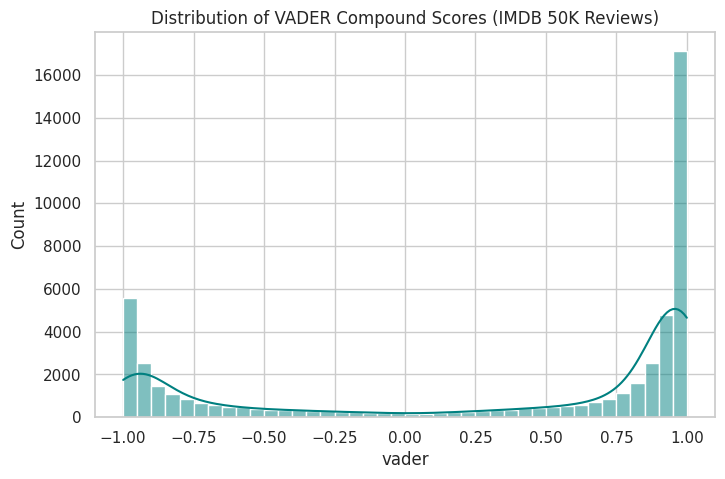

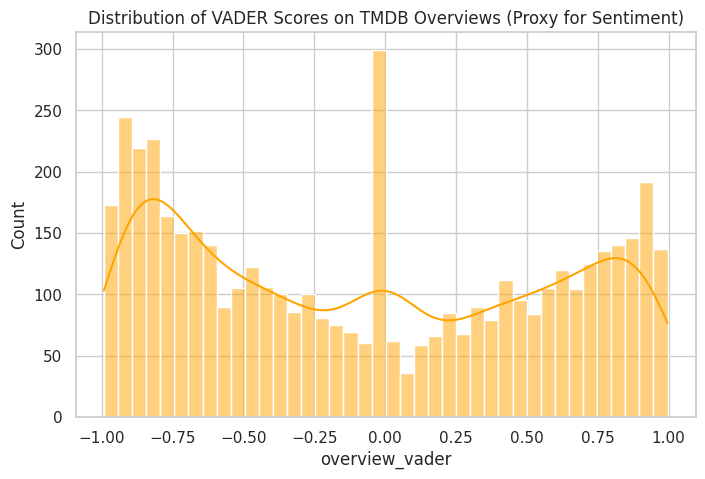

In [5]:
# VADER Sentiment
# -----------------------------
analyzer = SentimentIntensityAnalyzer()

def vader_score(text):
    return analyzer.polarity_scores(str(text))["compound"]

print("\nRunning VADER sentiment on 5 sample reviews...")
print(reviews["review"].head(5).apply(vader_score))

# Validate on sample vs IMDB labels
reviews["vader"] = reviews["review"].apply(vader_score)
reviews["label_bin"] = reviews["sentiment"].map({"positive":1,"negative":0})
reviews["pred_bin"] = (reviews["vader"]>=0.05).astype(int)
acc = (reviews["label_bin"]==reviews["pred_bin"]).mean()
print(f"✅ VADER accuracy vs labels: {acc:.3f}")

plt.figure(figsize=(8,5))
sns.histplot(reviews["vader"], bins=40, kde=True, color="teal")
plt.title("Distribution of VADER Compound Scores (IMDB 50K Reviews)")
plt.show()

# Use TMDB 'overview' as proxy for movie sentiment
tmdb["overview_vader"] = tmdb["overview"].fillna("").apply(vader_score)
plt.figure(figsize=(8,5))
sns.histplot(tmdb["overview_vader"], bins=40, kde=True, color="orange")
plt.title("Distribution of VADER Scores on TMDB Overviews (Proxy for Sentiment)")
plt.show()

In [6]:
# Merge & Features
# -----------------------------
movies = tmdb.copy()
movies["log_budget"]  = np.log1p(movies["budget"])
movies["log_revenue"] = np.log1p(movies["revenue"])
movies["release_month"] = pd.to_datetime(movies["release_date"], errors="coerce").dt.month.fillna(0).astype(int)
movies["num_genres"] = movies["genre_list"].apply(len)
movies["vader_mean"] = movies["overview_vader"]

top_genres = movies["primary_genre"].value_counts().index[:10]
for g in top_genres:
    movies[f"genre_{g}"] = (movies["primary_genre"]==g).astype(int)

features = ["log_budget","popularity","vote_average","vote_count",
            "runtime","num_genres","vader_mean","release_month"] + [f"genre_{g}" for g in top_genres]

movies_model = movies[movies["revenue"]>0].dropna(subset=features+["log_revenue"])
print("Model rows:", len(movies_model))
display(movies_model[["title","log_budget","log_revenue","vader_mean","primary_genre"]].head(5))

Model rows: 3376


,title,log_budget,log_revenue,vader_mean,primary_genre
0,Avatar,19.283571,21.748578,-0.3612,Action
1,Pirates of the Caribbean: At World's End,19.519293,20.683485,-0.3919,Adventure
2,Spectre,19.316769,20.596199,-0.8271,Action
3,The Dark Knight Rises,19.336971,20.804790,-0.9136,Action
4,John Carter,19.376192,19.464974,-0.7096,Action


In [8]:
# Train/Test Split
# -----------------------------
X = movies_model[features]
y = movies_model["log_revenue"]
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=RND)

scaler = ColumnTransformer([("num", StandardScaler(),
                              ["log_budget","popularity","vote_average","vote_count",
                               "runtime","num_genres","vader_mean","release_month"])],
                              remainder="passthrough")

def evaluate(name, model, Xte, yte):
    p = model.predict(Xte)
    rmse = math.sqrt(mean_squared_error(yte,p))
    mae  = mean_absolute_error(yte,p)
    r2   = r2_score(yte,p)
    print(f"\n{name} ➤ RMSE:{rmse:.3f}  MAE:{mae:.3f}  R²:{r2:.3f}")
    plt.figure(figsize=(6,6))
    plt.scatter(yte,p,alpha=0.4)
    plt.plot([yte.min(),yte.max()],[yte.min(),yte.max()],'r--')
    plt.title(f"{name}: Actual vs Predicted log(revenue)")
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.show()


Linear Regression ➤ RMSE:1.747  MAE:1.132  R²:0.417


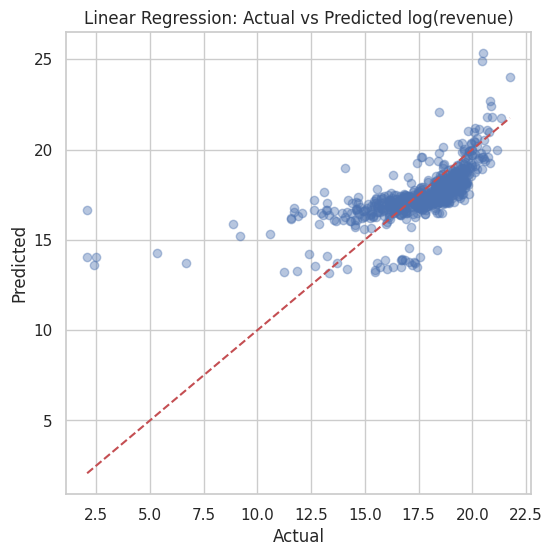


Random Forest ➤ RMSE:1.392  MAE:0.851  R²:0.630


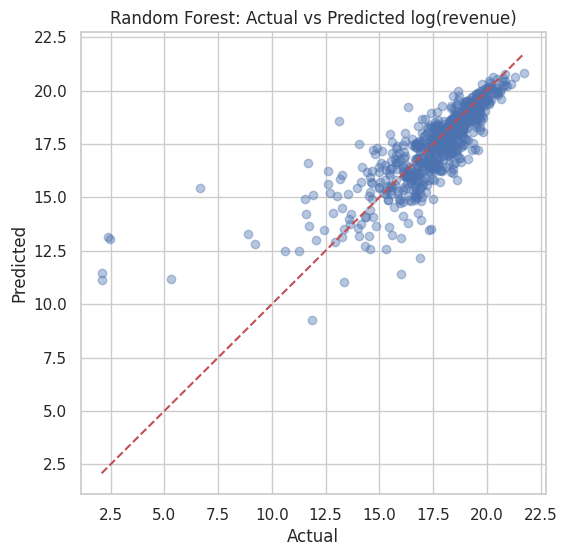


XGBoost ➤ RMSE:1.492  MAE:0.922  R²:0.575


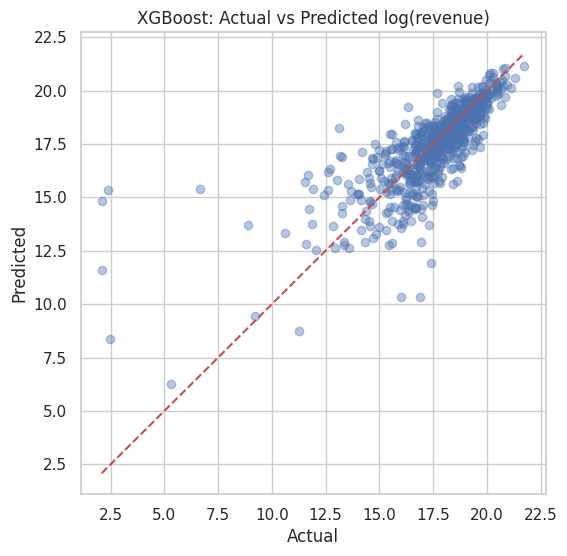

In [9]:
# Models
# ----------------------------
pipe_lr  = Pipeline([("prep",scaler),("lr",LinearRegression())]).fit(Xtr,ytr)
evaluate("Linear Regression", pipe_lr, Xte, yte)

pipe_rf  = Pipeline([("prep",scaler),("rf",RandomForestRegressor(n_estimators=200,random_state=RND,n_jobs=-1))]).fit(Xtr,ytr)
evaluate("Random Forest", pipe_rf, Xte, yte)

pipe_xgb = Pipeline([("prep",scaler),("xgb",XGBRegressor(n_estimators=300,random_state=RND,verbosity=0))]).fit(Xtr,ytr)
evaluate("XGBoost", pipe_xgb, Xte, yte)


Top Feature Importances (RandomForest):


,0
vote_count,0.405520
log_budget,0.216183
popularity,0.084812
runtime,0.068069
vote_average,0.052835
vader_mean,0.051929
release_month,0.043382
num_genres,0.026420
genre_Thriller,0.012692
genre_Fantasy,0.007806


/tmp/ipython-input-2340798396.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp.head(10), y=imp.head(10).index, palette="viridis")


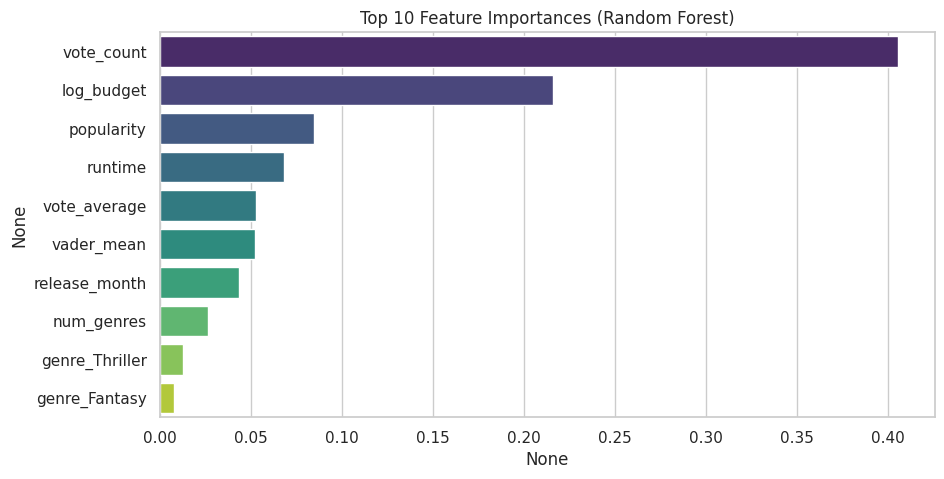

In [10]:
# Feature Importance
# -----------------------------
rf = pipe_rf.named_steps["rf"]
fn = ["log_budget","popularity","vote_average","vote_count",
      "runtime","num_genres","vader_mean","release_month"] + [f"genre_{g}" for g in top_genres]
imp = pd.Series(rf.feature_importances_, index=fn).sort_values(ascending=False)
print("\nTop Feature Importances (RandomForest):")
display(imp.head(10))

plt.figure(figsize=(10,5))
sns.barplot(x=imp.head(10), y=imp.head(10).index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

/tmp/ipython-input-1314908771.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gavg.values, y=gavg.index, palette="coolwarm")


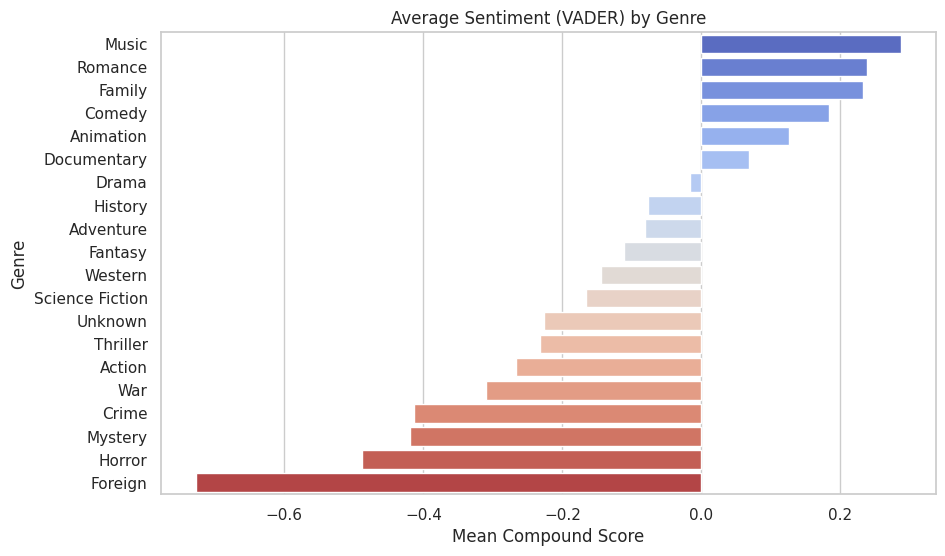

In [11]:
# Genre-wise Sentiment
# -----------------------------
gavg = movies_model.groupby("primary_genre")["vader_mean"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=gavg.values, y=gavg.index, palette="coolwarm")
plt.title("Average Sentiment (VADER) by Genre")
plt.xlabel("Mean Compound Score"); plt.ylabel("Genre")
plt.show()

In [13]:
# Summary
# -----------------------------
print("Data preview with model columns:")
display(movies_model.head(3))
print("\nFeature list used:", features)
print("\nInterpretation:")
print("- log_budget, popularity, and vote_count usually dominate revenue prediction.")
print("- Sentiment (vader_mean) adds moderate signal if real review data used.")
print("- For stronger results, add marketing & cast features.")

Data preview with model columns:


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,genre_Drama,genre_Comedy,genre_Action,genre_Adventure,genre_Horror,genre_Crime,genre_Thriller,genre_Animation,genre_Fantasy,genre_Romance
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,0,0,1,0,0,0,0,0,0,0
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,0,0,0,1,0,0,0,0,0,0
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,0,0,1,0,0,0,0,0,0,0



Feature list used: ['log_budget', 'popularity', 'vote_average', 'vote_count', 'runtime', 'num_genres', 'vader_mean', 'release_month', 'genre_Drama', 'genre_Comedy', 'genre_Action', 'genre_Adventure', 'genre_Horror', 'genre_Crime', 'genre_Thriller', 'genre_Animation', 'genre_Fantasy', 'genre_Romance']

Interpretation:
- log_budget, popularity, and vote_count usually dominate revenue prediction.
- Sentiment (vader_mean) adds moderate signal if real review data used.
- For stronger results, add marketing & cast features.
